# 基于MindFlow求解PINNs问题

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/zh_cn/features/mindspore_solve_pinns_by_mindflow.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/zh_cn/features/mindspore_solve_pinns_by_mindflow.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_zh_cn/features/solve_pinns_by_mindflow.ipynb)



## 概述

本教程基于二维Poisson问题介绍使用sympy定义第一类边界条件（Dirichlet boundary condition）和第二类边界条件（Neumann boundary condition），并训练一个物理信息神经网络模型。本教程主要介绍如下三个方面：

- 如何基于[MindFlow](https://mindspore.cn/mindflow/docs/zh-CN/master/index.html)使用sympy便捷定义偏微分方程；

- 如何在模型中定义第一类边界条件和第二类边界条件；

- 如何利用[MindSpore](https://mindspore.cn/docs/zh-CN/master/index.html)函数式编程范式训练一个物理信息神经网络。

## 问题描述

泊松方程是一个在理论物理中具有广泛效用的椭圆偏微分方程。例如，泊松方程的解是由给定电荷或质量密度分布引起的势场；在已知势场的情况下，可以计算静电或引力（力）场。
我们从二维齐次泊松方程出发，

$$
f + \Delta u = 0
$$

其中 `u` 是主变量， `f` 是源项， $\Delta$ 表示拉普拉斯运算符。

我们考虑源项 `f`为常数 ($f=1.0$)则泊松方程可以表示为：

$$
\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} + 1.0 = 0,
$$

本案例中，使用Dirichlet边界条件和Neumann边界条件。格式如下：

外圆边界上的Dirichlet边界条件：

$$
u = 0
$$

内圆边界上的Neumann边界条件：

$$
du/dn = 0
$$

本案例利用PINNs方法学习 $(x, y) \mapsto u$，实现泊松方程的求解。

## 技术路径

MindFlow求解该问题的具体流程如下：

1. 创建数据集。
2. 构建模型。
3. 优化器。
4. Poisson2D。
5. 模型训练。
6. 模型推理及可视化。

### 导入依赖库


In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import sympy
from sympy import symbols, Function, diff

import mindspore as ms
from mindspore import nn, ops, Tensor, set_context, set_seed, jit
from mindspore import dtype as mstype


set_seed(123456)
set_context(mode=ms.GRAPH_MODE, device_target="GPU", device_id=0)


## 创建数据集

本案例根据求解域、边值条件进行随机采样，使用[Disk](https://mindspore.cn/mindflow/docs/zh-CN/master/mindflow.geometry.html#mindflow.geometry.Disk)和[CSGXOR](https://mindspore.cn/mindflow/docs/zh-CN/master/mindflow.geometry.html#mindflow.geometry.CSGXOR)几何模块构建输入输出边界和作用域，生成训练数据集与测试数据集。`Disk`和`CSGXOR`由`MindFlow`的[geometry](https://mindspore.cn/mindflow/docs/zh-CN/master/mindflow.geometry.html#)模块导入。下载数据生成的[Python文件](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/features/solve_pinns_by_mindflow/src/dataset.py)。

In [2]:
from mindflow.geometry import generate_sampling_config, Disk, CSGXOR

class MyIterable:
    def __init__(self, domain, bc_outer, bc_inner, bc_inner_normal):
        self._index = 0
        self._domain = domain.astype(np.float32)
        self._bc_outer = bc_outer.astype(np.float32)
        self._bc_inner = bc_inner.astype(np.float32)
        self._bc_inner_normal = bc_inner_normal.astype(np.float32)

    def __next__(self):
        if self._index >= len(self._domain):
            raise StopIteration

        item = (self._domain[self._index], self._bc_outer[self._index], self._bc_inner[self._index],
                self._bc_inner_normal[self._index])
        self._index += 1
        return item

    def __iter__(self):
        self._index = 0
        return self

    def __len__(self):
        return len(self._domain)


def _get_region(config):
    indisk_cfg = config["in_disk"]
    in_disk = Disk(indisk_cfg["name"], (indisk_cfg["center_x"], indisk_cfg["center_y"]), indisk_cfg["radius"])
    outdisk_cfg = config["out_disk"]
    out_disk = Disk(outdisk_cfg["name"], (outdisk_cfg["center_x"], outdisk_cfg["center_y"]), outdisk_cfg["radius"])
    union = CSGXOR(out_disk, in_disk)
    return in_disk, out_disk, union


def create_training_dataset(config):
    '''create_training_dataset'''
    in_disk, out_disk, union = _get_region(config)

    union.set_sampling_config(generate_sampling_config(config["data"]))
    domain = union.sampling(geom_type="domain")

    out_disk.set_sampling_config(generate_sampling_config(config["data"]))
    bc_outer, _ = out_disk.sampling(geom_type="BC")

    in_disk.set_sampling_config(generate_sampling_config(config["data"]))
    bc_inner, bc_inner_normal = in_disk.sampling(geom_type="BC")

    plt.figure()
    plt.axis("equal")
    plt.scatter(domain[:, 0], domain[:, 1], c="powderblue", s=0.5)
    plt.scatter(bc_outer[:, 0], bc_outer[:, 1], c="darkorange", s=0.005)
    plt.scatter(bc_inner[:, 0], bc_inner[:, 1], c="cyan", s=0.005)
    plt.show()
    dataset = ms.dataset.GeneratorDataset(source=MyIterable(domain, bc_outer, bc_inner, (-1.0) * bc_inner_normal),
                                          column_names=["data", "bc_outer", "bc_inner", "bc_inner_normal"])
    return dataset


def _numerical_solution(x, y):
    return (4.0 - x ** 2 - y ** 2) / 4


def create_test_dataset(config):
    """create test dataset"""
    _, _, union = _get_region(config)
    union.set_sampling_config(generate_sampling_config(config["data"]))
    test_data = union.sampling(geom_type="domain")
    test_label = _numerical_solution(test_data[:, 0], test_data[:, 1]).reshape(-1, 1)
    return test_data, test_label


数据生成的几何形状为一个圆环，内圆半径为1.0，外圆半径为2.0，边界和域内数据量大小均为8192。具体生成参数设置如下：

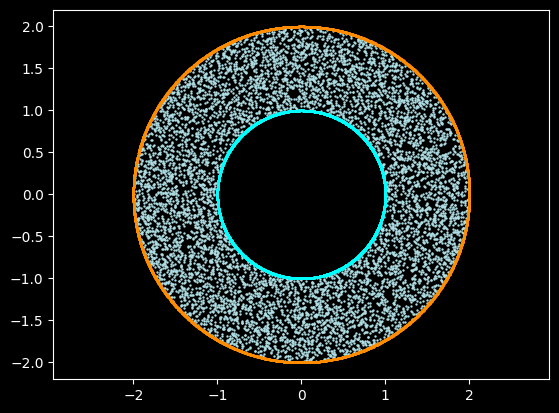

In [3]:
in_disk = {"name": "in_disk", "center_x": 0.0, "center_y": 0.0, "radius": 1.0}
out_disk = {"name": "out_disk", "center_x": 0.0, "center_y": 0.0, "radius": 2.0}
domain = {"size": 8192, "random_sampling": True, "sampler": "uniform"}
BC = {"size": 8192, "random_sampling": True, "sampler": "uniform", "with_normal": True}
data = {"domain": domain, "BC": BC}
config = {"in_disk": in_disk, "out_disk": out_disk, "data": data}

# create training dataset
dataset = create_training_dataset(config)
train_dataset = dataset.batch(batch_size=8192)

# create test dataset
inputs, label = create_test_dataset(config)

## 构建模型

本例使用[MultiScaleFCCell](https://mindspore.cn/mindflow/docs/zh-CN/master/mindflow.cell.html#mindflow.cell.MultiScaleFCCell)构建网络模型。`MultiScaleFCCell`网络由`MindFlow`的[cell](https://mindspore.cn/mindflow/docs/zh-CN/master/mindflow.cell.html)模块导入。所构建的全连接网络，深度为6层，激活函数为`tanh`函数。

In [4]:
from mindflow.cell import MultiScaleFCCell

model = MultiScaleFCCell(in_channels=2,
                         out_channels=1,
                         layers=6,
                         neurons=128,
                         residual=False,
                         act="tanh",
                         num_scales=1)

## 优化器

优化器使用Adaptive Moment Estimation (Adam)。

In [5]:
optimizer = nn.Adam(model.trainable_params(), 0.001)


## Poisson2D

`Poisson2D`包含求解问题的控制方程、狄利克雷边界条件、诺曼边界条件等。使用`sympy`以符号形式定义偏微分方程并求解所有方程的损失值。

### 符号声明

定义`x`、 `y`、 `n`分别表示横坐标、纵坐标和内圆边界的法向量。输出`u`为关于`x`和 `y`的函数。

In [6]:
x, y, n = symbols('x y n')
u = Function('u')(x, y)

# independent variables
in_vars = [x, y]
print("independent variables: ", in_vars)

# dependent variables
out_vars = [u]
print("dependent variables: ", out_vars)

independent variables:  [x, y]
dependent variables:  [u(x, y)]


### 控制方程

In [7]:
govern_eq = diff(u, (x, 2)) + diff(u, (y, 2)) + 1.0
print("governing equation: ", govern_eq)

governing equation:  Derivative(u(x, y), (x, 2)) + Derivative(u(x, y), (y, 2)) + 1.0


### Dirichlet边界条件

In [8]:
bc_outer = u
print("bc_outer equation: ", bc_outer)

bc_outer equation:  u(x, y)


### Neumann边界条件

In [9]:
bc_inner = sympy.Derivative(u, n) - 0.5
print("bc_inner equation: ", bc_inner)

bc_inner equation:  Derivative(u(x, y), n) - 0.5


基于[Poisson](https://mindspore.cn/mindflow/docs/zh-CN/master/mindflow.pde.html#mindflow.pde.Poisson)基类结合上面定义的控制方程和边界条件，定义下述`Poisson2D`问题。`Poisson`基类由`MindFlow`的[pde](https://mindspore.cn/mindflow/docs/zh-CN/master/mindflow.pde.html)模块导入。下载`Poisson2D`问题的[Python文件](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/features/solve_pinns_by_mindflow/src/model.py)。

In [10]:
from mindflow.pde import Poisson, sympy_to_mindspore

class Poisson2D(Poisson):
    def __init__(self, model, loss_fn="mse"):
        super(Poisson2D, self).__init__(model, loss_fn=loss_fn)
        self.bc_outer_nodes = sympy_to_mindspore(self.bc_outer(), self.in_vars, self.out_vars)
        self.bc_inner_nodes = sympy_to_mindspore(self.bc_inner(), self.in_vars, self.out_vars)

    def bc_outer(self):
        bc_outer_eq = self.u
        equations = {"bc_outer": bc_outer_eq}
        return equations

    def bc_inner(self):
        bc_inner_eq = sympy.Derivative(self.u, self.normal) - 0.5
        equations = {"bc_inner": bc_inner_eq}
        return equations

    def get_loss(self, pde_data, bc_outer_data, bc_inner_data, bc_inner_normal):
        pde_res = self.parse_node(self.pde_nodes, inputs=pde_data)
        pde_loss = self.loss_fn(pde_res[0], Tensor(np.array([0.0]), mstype.float32))

        bc_inner_res = self.parse_node(self.bc_inner_nodes, inputs=bc_inner_data, norm=bc_inner_normal)
        bc_inner_loss = self.loss_fn(bc_inner_res[0], Tensor(np.array([0.0]), mstype.float32))

        bc_outer_res = self.parse_node(self.bc_outer_nodes, inputs=bc_outer_data)
        bc_outer_loss = self.loss_fn(bc_outer_res[0], Tensor(np.array([0.0]), mstype.float32))

        return pde_loss + bc_inner_loss + bc_outer_loss

problem = Poisson2D(model)

poisson: Derivative(u(x, y), (x, 2)) + Derivative(u(x, y), (y, 2)) + 1.0
    Item numbers of current derivative formula nodes: 3
bc_outer: u(x, y)
    Item numbers of current derivative formula nodes: 1
bc_inner: Derivative(u(x, y), n) - 0.5
    Item numbers of current derivative formula nodes: 2


## 模型训练

使用**MindSpore >= 2.0.0**的版本，采用函数式编程的方式训练网络。下载训练的[Python文件](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/features/solve_pinns_by_mindflow/train.py)。

In [11]:
# define forward function
def forward_fn(pde_data, bc_outer_data, bc_inner_data, bc_inner_normal):
    loss = problem.get_loss(pde_data, bc_outer_data, bc_inner_data, bc_inner_normal)
    return loss

# define grad function
grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

# using jit to accelerate training
@jit
def train_step(pde_data, bc_outer_data, bc_inner_data, bc_inner_normal):
    loss, grads = grad_fn(pde_data, bc_outer_data, bc_inner_data, bc_inner_normal)
    loss = ops.depend(loss, optimizer(grads))
    return loss


下载训练过程计算损失的[Python文件](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/features/solve_pinns_by_mindflow/src/utils.py)。

In [12]:
def _calculate_error(label, prediction):
    '''calculate l2-error to evaluate accuracy'''
    error = label - prediction
    l2_error = np.sqrt(np.sum(np.square(error[..., 0]))) / np.sqrt(np.sum(np.square(label[..., 0])))

    return l2_error


def _get_prediction(model, inputs, label_shape, batch_size):
    '''calculate the prediction respect to the given inputs'''
    prediction = np.zeros(label_shape)
    prediction = prediction.reshape((-1, label_shape[1]))
    inputs = inputs.reshape((-1, inputs.shape[1]))

    time_beg = time.time()

    index = 0
    while index < inputs.shape[0]:
        index_end = min(index + batch_size, inputs.shape[0])
        test_batch = Tensor(inputs[index: index_end, :], mstype.float32)
        prediction[index: index_end, :] = model(test_batch).asnumpy()
        index = index_end

    print("    predict total time: {} ms".format((time.time() - time_beg) * 1000))
    prediction = prediction.reshape(label_shape)
    prediction = prediction.reshape((-1, label_shape[1]))
    return prediction


def calculate_l2_error(model, inputs, label, batch_size):
    label_shape = label.shape
    prediction = _get_prediction(model, inputs, label_shape, batch_size)
    label = label.reshape((-1, label_shape[1]))
    l2_error = _calculate_error(label, prediction)
    print("    l2_error: ", l2_error)
    print("==================================================================================================")


In [13]:
epochs = 5000
steps_per_epochs = train_dataset.get_dataset_size()
sink_process = ms.data_sink(train_step, train_dataset, sink_size=1)

for epoch in range(1, epochs + 1):
    # train
    time_beg = time.time()
    model.set_train(True)
    for _ in range(steps_per_epochs):
        step_train_loss = sink_process()
    print(f"epoch: {epoch} train loss: {step_train_loss} epoch time: {(time.time() - time_beg)*1000 :.3f} ms")
    model.set_train(False)
    if epoch % 100 == 0:
        # eval
        calculate_l2_error(model, inputs, label, 8192)

epoch: 1 train loss: 1.2577767 epoch time: 6024.162 ms
epoch: 2 train loss: 1.2554792 epoch time: 70.884 ms
epoch: 3 train loss: 1.2534575 epoch time: 71.048 ms
epoch: 4 train loss: 1.2516733 epoch time: 100.632 ms
epoch: 5 train loss: 1.2503157 epoch time: 65.656 ms
epoch: 6 train loss: 1.2501826 epoch time: 137.487 ms
epoch: 7 train loss: 1.2511331 epoch time: 51.191 ms
epoch: 8 train loss: 1.2508672 epoch time: 65.980 ms
epoch: 9 train loss: 1.2503275 epoch time: 211.144 ms
epoch: 10 train loss: 1.2500556 epoch time: 224.515 ms
epoch: 11 train loss: 1.2500004 epoch time: 225.964 ms
epoch: 12 train loss: 1.2500298 epoch time: 220.117 ms
epoch: 13 train loss: 1.2500703 epoch time: 221.441 ms
epoch: 14 train loss: 1.2500948 epoch time: 220.214 ms
epoch: 15 train loss: 1.2500978 epoch time: 219.836 ms
epoch: 16 train loss: 1.250083 epoch time: 220.141 ms
epoch: 17 train loss: 1.2500567 epoch time: 229.682 ms
epoch: 18 train loss: 1.2500263 epoch time: 216.013 ms
epoch: 19 train loss: 1.

## 模型推理及可视化

训练后可对流场内所有数据点进行推理，并可视化相关结果。下载可视化结果的[Python文件](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/features/solve_pinns_by_mindflow/src/utils.py)。

In [14]:
def visual(model, inputs, label, epochs=1):
    '''visual result for poisson 2D'''
    fig, ax = plt.subplots(2, 1)
    ax = ax.flatten()
    plt.subplots_adjust(hspace=0.5)
    ax0 = ax[0].scatter(inputs[:, 0], inputs[:, 1], c=label[:, 0], cmap=plt.cm.rainbow, s=0.5)
    ax[0].set_title("true")
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].axis('equal')
    ax[1].scatter(inputs[:, 0], inputs[:, 1], c=model(Tensor(inputs, mstype.float32)), cmap=plt.cm.rainbow, s=0.5)
    ax[1].set_title("prediction")
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    ax[1].axis('equal')
    cbar = fig.colorbar(ax0, ax=[ax[0], ax[1]])
    cbar.set_label('u(x, y)')

    plt.savefig(f"images/{epochs}-result.jpg", dpi=600)


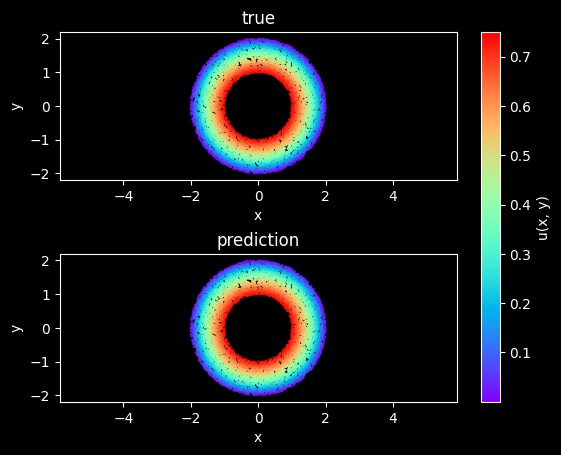

In [15]:
# visualization
visual(model, inputs, label, 5000)